# 5.1 합성곱 신경망 소개
- 컨브넷(convnet) - 합성곱 신경망(convolution neural network)
- 대부분의 컴퓨터 비전(computher vision) 애플리케이션에 사용됨
- 2장에서 완전 연결 네트워크로 풀었던(98%의 정확도) MNIST 숫자 이미지 분류에 컨브넷 사용 예제

### 간단한 컨브넷 만들기
- `Conv2D`, `MaxPooling2D` 층을 쌓아 올림
- `(image_height, image_width, image_channels)` 크기의 입력 텐서를 사용한다는 사실이 중요

In [1]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

### 컨브넷 구조
- `model.summary()` = `tensorflow.keras.utils.print_summary(model)`
- `Conv2D`와 `MaxPooling2D` 층의 출력은 `(height, width, channels)` 크기의 3D 텐서
- 채널의 수는 `Conv2D` 층에 전달된 첫 번째 매개변수에 의해 조절

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


### 컨브넷 위에 분류기 추가하기
- 마지막 층의 `(3, 3, 64)` 크기의 출력 텐서를 완전 연결 네트워크에 주입
    - 3D 출력을 1D 텐서로 펼쳐야 함

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

### MNIST 이미지에 컨브넷 훈련하기

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 13s 5ms/step - loss: 0.1807 - accuracy: 0.9432
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0480 - accuracy: 0.9857
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0334 - accuracy: 0.9896
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0251 - accuracy: 0.9921
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0197 - accuracy: 0.9938


### 모델 평가
- 완전 연결 네트워크 모델(98%)보다 정확도 증가(99%)

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0274 - accuracy: 0.9920
0.9919999837875366


## 5.1.1 합성곱 연산
- `Dense` 층은 입력 특성 공간에 있는 전역 패턴을 학습
- 합성곱 층은 지역 패턴을 학습
    - 이미지의 경우 2D 윈도우로 입력에서 패턴을 찾음 (앞의 예제에서는 3x3 크기)
- 컨브넷의 성질
    - **학습된 패턴은 평행 이동 불변성**(translation invariant)**을 가짐** : 컨브넷이 어떤 패턴을 학습했다면 다른 곳에서도 이 패턴을 인식할 수 있음
        - 반면 완전 연결 네트워크는 새로운 위치에 나타난 것은 새로운 패턴으로 학습함
    - **컨브넷은 패턴의 공간적 게층 구조를 학습할 수 있음**
        - 첫 번째 합성곱 층이 에지 같은 작은 지역 패턴을 학습
        - 두 번째 합성곱 층은 첫 번째 층의 특성으로 구성된 더 큰 패턴을 학습
        - 복잡하고 추상적인 시각적 개념을 효과적으로 학습
- **특성 맵**(feature map)이라고 부르는 3D 텐서에 적용
    - 2개의 공간 축(**높이**와 **너비**)과 **깊이** 축(**채널** 축)으로 구성됨
- 컨브넷은 특성 맵에서 작은 패치(patch)들을 추출하고 모든 패치에 같은 변환을 적용하여 **출력 특성 맵**(output feature map)을 만듦
    - 출력 텐서의 깊이는 층의 매개변수로 결정되며 RGB 입력처럼 특정 컬러를 의미하지 않음
    - 일종의 **필터**(filter)를 의미 : 입력 데이터의 어떤 특성을 인코딩
    - 필터 하나의 크기 : `(patch_height, patch_width, input_depth)`
        - 첫 번째 합성곱 층의 필터 : `(3, 3, 1)` 32개
        - 두 번째 합성곱 층의 필터 : `(3, 3, 32)` 64개
- **응답 맵**(response map) : 합성곱 층의 출력이 가지는 배열 값(26x26 크기의 32개 출력)으로 입력의 각 위치에서 필터 패턴에 대한 응답
- **특성 맵** : 깊이 축에 있는 각 차원은 하나의 특성이며 2D 텐서는 입력에 대한 이 필터 응답을 나타내는 2D 공간상의 맵
- 합성곱의 핵심적인 파라미터
    - **입력으로부터 뽑아낼 패치의 크기** : 일반적으로 3x3 또는 5x5 크기를 사용
        - 3D 입력 특성 맵 위를 윈도우가 **슬라이딩**(sliding)하면서 모든 위치에서 3D 특성 패치를 추출하는 방식
        - 이런 3D 패치는 `(output_depth,)` 크기의 1D 벡터로 변환됨(**합성곱 커널**(convolution kernel)과의 텐서 곱셈을 통하여)
            - 합성곱 커널 : 합성곱 층의 필터를 하나의 행렬로 합친 것
    - **특성 맵의 출력 깊이** : 합성곱으로 계산할 필터의 수
    
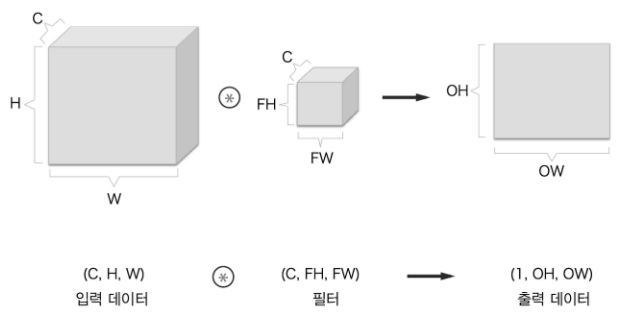
https://deep-learning-study.tistory.com/181

### 경계 문제와 패딩 이해하기
- **패딩**(padding) : 입력 특성 맵의 가장자리에 적절한 개수의 행과 열을 추가하여 입력과 동일한 높이와 너비를 가진 출력 특성 맵을 얻는 것
- `padding` 매개변수
    - `valid` : 패딩을 사용하지 않음 (기본값)
    - `same` : 패딩 사용

### 합성곱 스트라이드 이해하기
- **스트라이드** : 기본값은 1로 윈도우 사이의 거리
- 스트라이드가 1보다 큰 **스트라이드 합성곱**도 가능
    - 스트라이드 2 : 특성 맵의 너비와 높이가 2의 배수로 다운샘플링
    - 드물게 사용되지만 어떤 모델에서는 유용하게 사용됨

## 5.1.2 최대 풀링 연산
- 최대 풀링 : 입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 채널별로 최댓값을 출력
- 2 x 2 윈도우와 스트라이드 2를 사용하여 특성 맵을 절반 크기로 다운샘플링
    - 합성곱은 3 x 3 윈도우와 스트라이드 1을 사용

### 합성곱으로만 이루어진 모델
- 문제점
    - 특성의 공간적 계층 구조를 학습하는데 도움이 되지 않음
        - 마지막 층의 3x3 윈도우는 초기 입력의 7x7 윈도우 영역에 대한 정보만 갖고 있음
        - 초기 입력에 관한 정보가 아주 적어 학습하기에 충분하지 않음
        - 마지막 합성곱 층의 특성이 전체 입력에 대한 정보를 가지고 있어야 함
    - 최종 특성 맵이 22 x 22 x 64 = 30,976개의 원소로 매우 많아 `Dense` 층과 연결 시 가중치가 많아 과대적합 발생

In [8]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_no_max_pool.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


- **평균 풀링**(average pooling)을 사용할 수도 있으나 최대 풀링이 특성을 더 잘 뽑아냄
- 가장 납득할 만한 서브샘플링(subsampling) 전략은 (스트라이드가 없는 합성곱으로) 조밀한 특성 맵을 만들고 그 다음 작은 패치에 대해서 최대로 활성화된 특성을 고르는 것